In [1]:
import psycopg2
import pandas as pd
import requests
from bs4 import BeautifulSoup

from requests.auth import HTTPBasicAuth
from config import config

params = config()
conn = psycopg2.connect(**params)
cur = conn.cursor()
cur.execute('select deteccion, municipio, paraje, superficiearboladatotal, superficinoarboladatotal from inc_ze order by superficiearboladatotal + superficinoarboladatotal desc')
d = cur.fetchall()
cur.close()
conn.close()
datos = [[],[],[],[],[],[],[]]
for i in d:
    datos[0].append(i[0].strftime('%d/%m/%Y'))
    datos[1].append(i[1])
    datos[2].append(i[2])
    datos[3].append(i[3])
    datos[4].append(i[4])
    datos[5].append(i[3]+i[4])

df = pd.DataFrame({
    'fecha': datos[0],
    'municipio': datos[1],
    'paraje': datos[2],
    'sup arbolada': datos[3],
    'sup no arbolada': datos[4],
    'sup total': datos[5],
})
display(df[:20])

,fecha,municipio,paraje,sup arbolada,sup no arbolada,sup total
0,12/08/2003,JERTE,PINAJARRO,100.00,700.00,800.00
1,14/10/2011,HERVAS,ARROYO DEL POSTURILLO O DEL HORCAJO,40.53,334.73,375.26
2,02/07/2002,VILLANUEVA DE LA VERA,MESALLANA,60.00,240.00,300.00
3,11/04/2017,JERTE,None,165.99,104.90,270.89
4,12/02/2005,TORNAVACAS,LA CAMPANA (JERCO DEL RIO),0.00,219.00,219.00
5,24/12/2011,TORNAVACAS,MINGOSANCHO,0.00,207.00,207.00
6,11/04/2017,JERTE,DEHESA EJIDO DE LA SOLANA,57.60,110.27,167.87
7,01/04/2011,JERTE,LA NIJARRA,0.00,159.28,159.28
8,12/01/2012,TORNAVACAS,CUESTA ROBLEDO,0.00,136.05,136.05
9,30/12/2004,TORNAVACAS,EL CARRAL,0.00,120.00,120.00



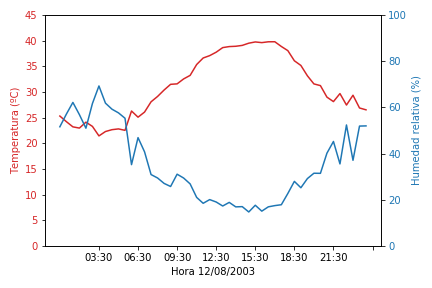


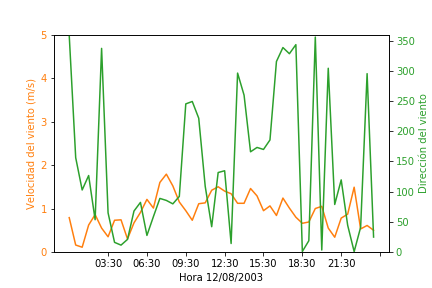


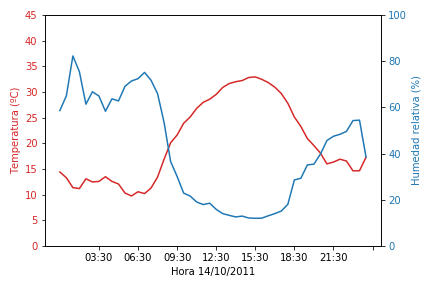


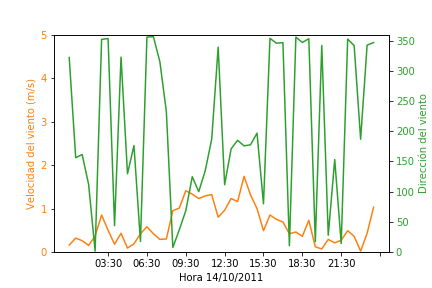


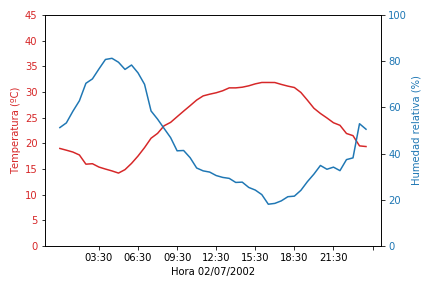


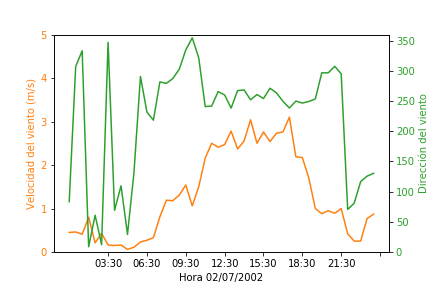


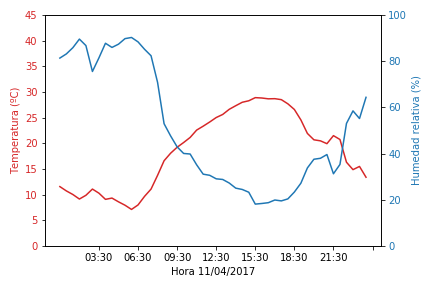


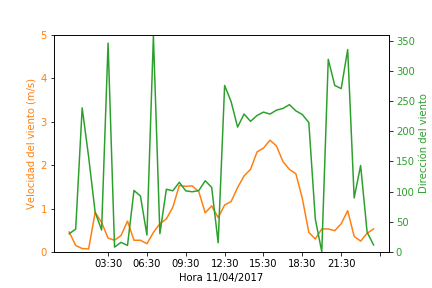


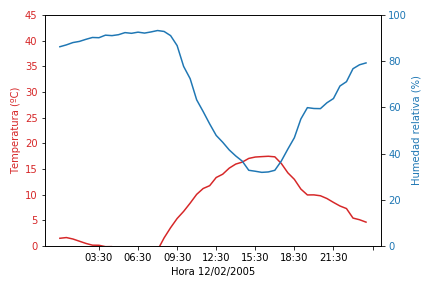


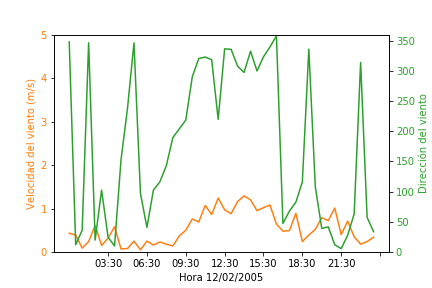


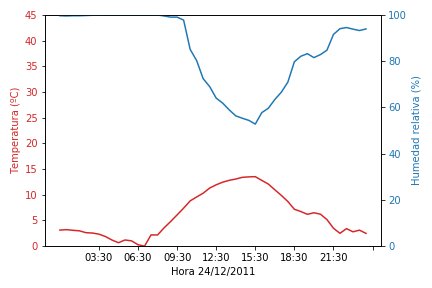


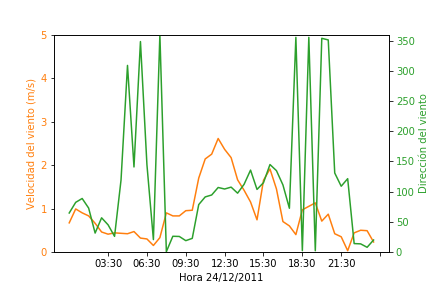


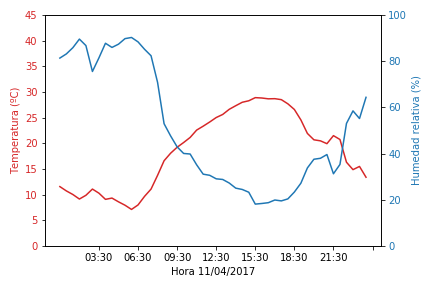


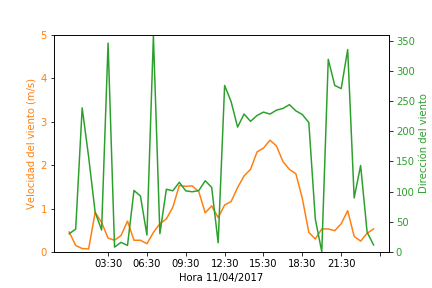


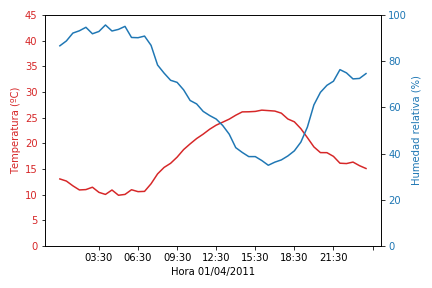


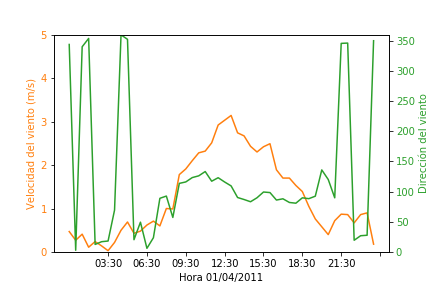


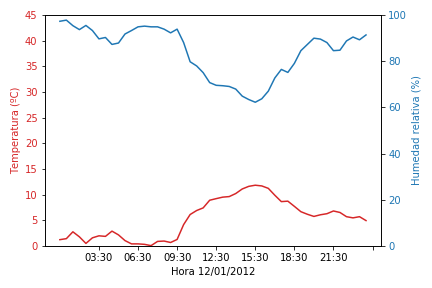


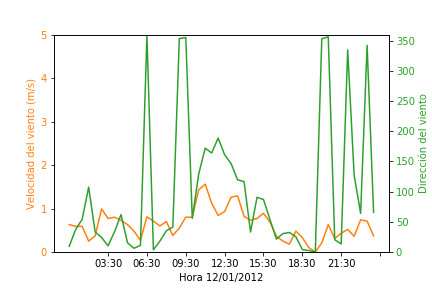


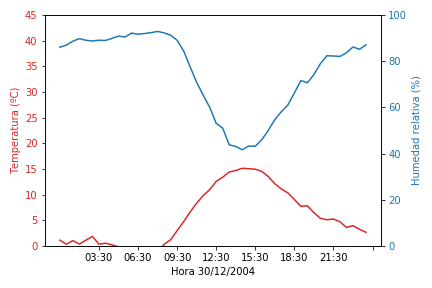


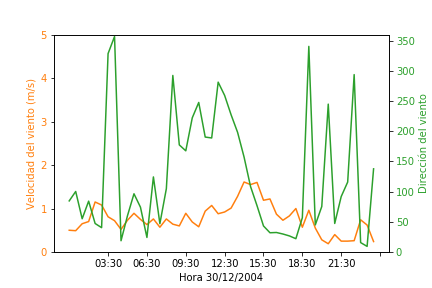


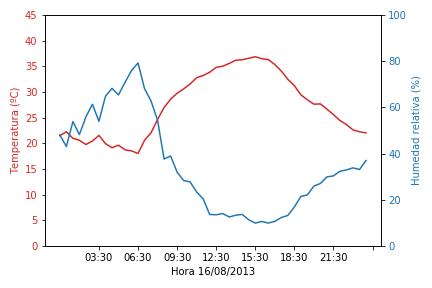


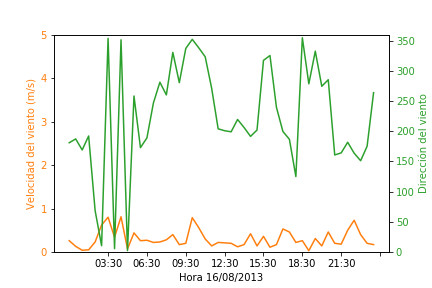


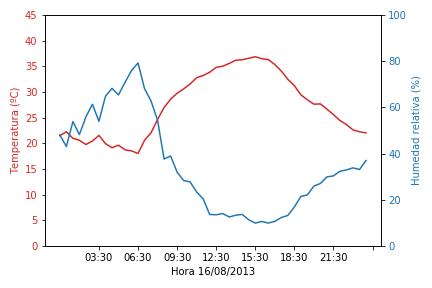


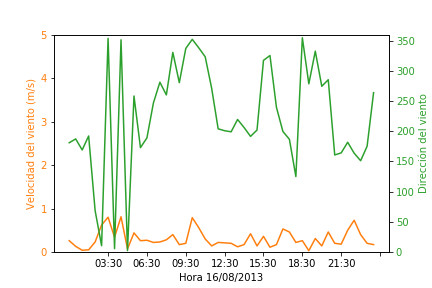


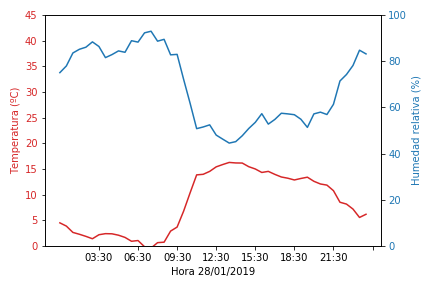


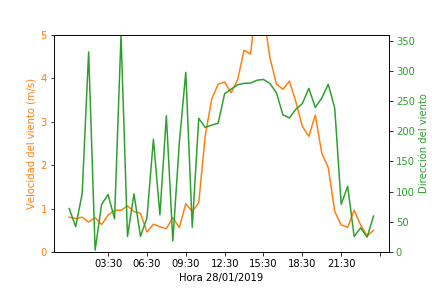


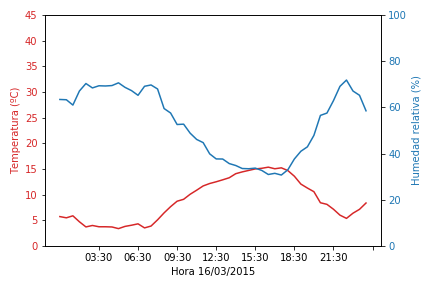


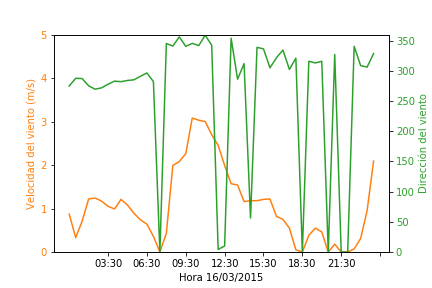


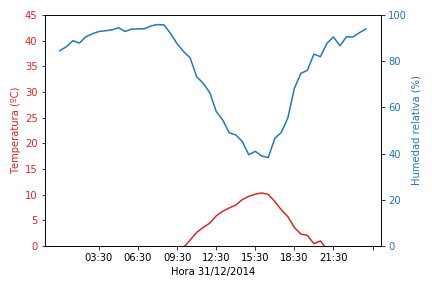


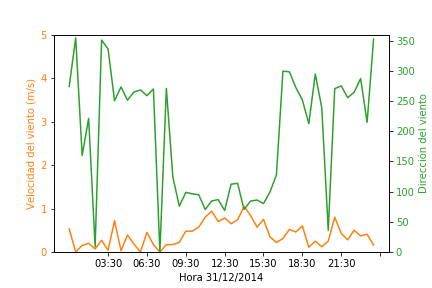


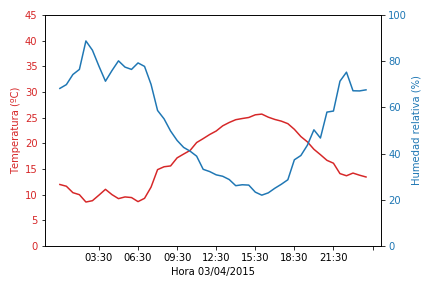


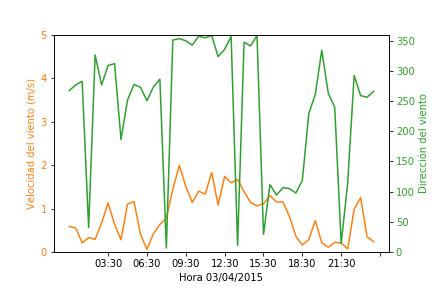


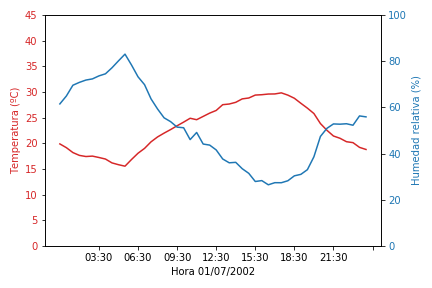


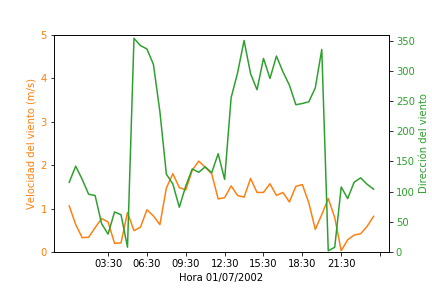


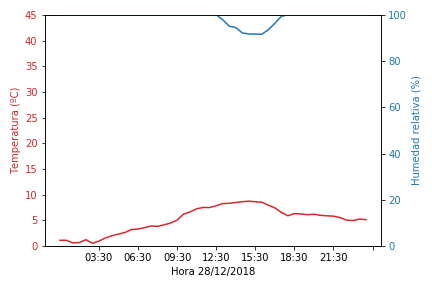


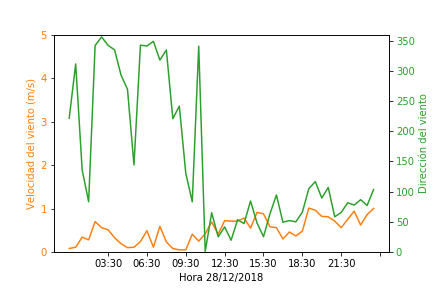


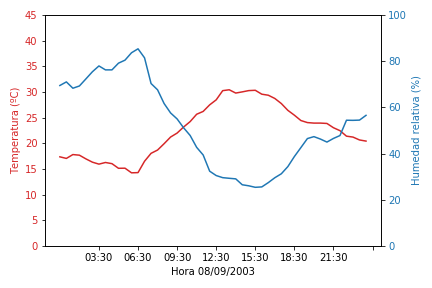


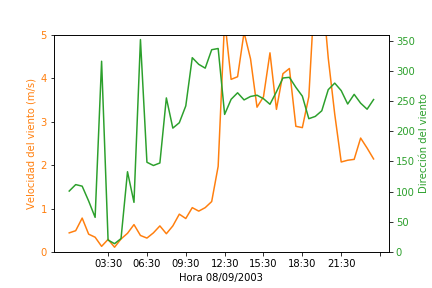


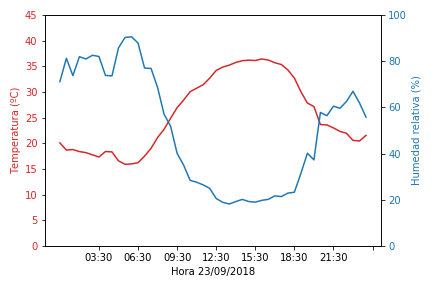


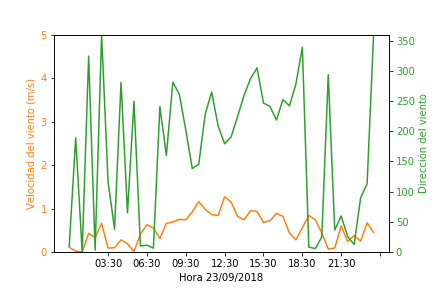

In [54]:
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import binascii
from io import BytesIO

for i in range(20):
    fecha = datos[0][i].split('/')
    dia = fecha[0]
    mes = fecha[1]
    anho = fecha[2]
    
    redarex_url = 'http://redarexplus.gobex.es/REDAREX_plus/index.php'
    redarex_data = {
        'fecha_desde':'{}/{}/{}'.format(dia,mes,anho), 
        'fecha_hasta':'{}/{}/{}'.format(dia,mes,anho), 
        'chkTempMedia':'on',
        'chkHumedadRelativaMed': 'on',
        'chkVelViento': 'on',
        'chkDireccionViento': 'on',
        'aceptar':'Consultar', 
        'estacionesSeleccionadas':'10_13'
    }
    date = []
    hora = []
    temp = []
    hrel = []
    velviento = []
    dirviento = []
    
    for n in range(0, 48, 12):
        redarex_params = {
            'modulo':'agrometeorologia', 
            'camino': 'Agrometeorolog%EDa', 
            'pagina':'datos.php', 
            'rango':'semihorarios', 
            'estacionesSeleccionadas': 
            '10_13', 
            'paginando':'on', 
            'limite':n
        }
        r = requests.post(redarex_url, params=redarex_params, auth=HTTPBasicAuth('bartulo@gmail.com', 'ventanuco'), data=redarex_data)
        soup = BeautifulSoup(r.content, 'html.parser')
        
        for j in range(12):
            a = soup.findAll('td', class_='txt_normal')
            date.append(a[j * 6 + 6].find('font').text.strip())
            hora.append(a[j * 6 + 7].find('font').text.strip())
            temp.append(float(a[j * 6 + 8].find('font').text.strip()))
            hrel.append(float(a[j * 6 + 9].find('font').text.strip()))
            velviento.append(float(a[j * 6 + 10].find('font').text.strip()))
            dirviento.append(float(a[j * 6 + 11].find('font').text.strip()))
            
    tabla = pd.DataFrame({'fecha': date, 'hora': hora, 'temperatura media': temp, 'humedad rel. media': hrel, 'velocidad viento':velviento, 'dirección viento': dirviento})

    bio = BytesIO()

    # PRIMER GRÁFICO
    
    fig, ax1 = plt.subplots()
    
    plt.ylim([0,45])
    color = 'tab:red'
    ax1.set_xlabel('Hora {}'.format(date[0]))
    ax1.set_ylabel('Temperatura (ºC)', color=color)
    ax1.plot(hora, temp, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()
    plt.ylim([0,100])
    color = 'tab:blue'
    ax2.set_ylabel('Humedad relativa (%)', color=color)
    ax2.plot(hora, hrel)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()
    plt.xticks([6, 12, 18, 24, 30, 36, 42, 48])

    fig.canvas.print_png(bio)
    plt.close(fig)
    
    img_data = binascii.b2a_base64(bio.getvalue()).decode()

    # SEGUNDO GRÁFICO
    
    bio2 = BytesIO()
    
    fig2, ax3 = plt.subplots()
    
    plt.ylim([0,5])
    color = 'tab:orange'
    ax3.set_xlabel('Hora {}'.format(date[0]))
    ax3.set_ylabel('Velocidad del viento (m/s)', color=color)
    ax3.plot(hora, velviento, color=color)
    ax3.tick_params(axis='y', labelcolor=color)
    
    ax4 = ax3.twinx()
    plt.ylim([0,360])
    color = 'tab:green'
    ax4.set_ylabel('Dirección del viento', color=color)
    ax4.plot(hora, dirviento, color=color)
    ax4.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()
    plt.xticks([6, 12, 18, 24, 30, 36, 42, 48])

    fig2.canvas.print_png(bio2)
    plt.close(fig2)
    
    img_data2 = binascii.b2a_base64(bio2.getvalue()).decode()

    
    display(HTML('<h1 style="text-align: center;">{} - {} - {}</h1><hr/><div style="white-space: nowrap"><img src="data:image/png;base64,{}&#10;"/>'.format(datos[0][i], datos[1][i], datos[2][i], img_data)))
    display(HTML('<img src="data:image/png;base64,{}&#10;"/></div>'.format(img_data2)))
    display(HTML('<img width="600px" src="https://www.wetterzentrale.de/maps/archive/{}/cfsr/CFSR_1_{}{}{}18_1.png"></img>'.format(anho,anho,mes,dia)))
    display(HTML('<img width="600px" src="https://www.wetterzentrale.de/maps/archive/{}/cfsr/CFSR_1_{}{}{}18_2.png"></img>'.format(anho,anho,mes,dia)))